### Subproblem 1

Plot daily sales for all 50 weeks.


In [29]:
# Check data
import pandas as pd
data_sample = pd.read_csv('./data/sales_week_starting_2012-10-01.csv')
data_sample.head()

,sale_time,purchaser_gender
0,2012-10-01 01:42:22,female
1,2012-10-01 02:24:53,female
2,2012-10-01 02:25:40,female
3,2012-10-01 02:30:42,female
4,2012-10-01 02:51:32,male


In [74]:
# Get all csv
import glob
csv_calls = [pd.read_csv(csv_path) for csv_path in glob.glob('./data/*.csv')]
csv_concat = pd.concat(csv_calls, axis=0)
csv_concat['sale_time'] = pd.to_datetime(csv_concat['sale_time']).dt.date
csv_concat.head()

,sale_time,purchaser_gender
0,2012-10-01,female
1,2012-10-01,female
2,2012-10-01,female
3,2012-10-01,female
4,2012-10-01,male


In [75]:
# Daily sales count
daily_sales = csv_concat.groupby(csv_concat['sale_time']).size().reset_index(name='daily_sales')
daily_sales

,sale_time,daily_sales
0,2012-10-01,514
1,2012-10-02,482
2,2012-10-03,499
3,2012-10-04,546
4,2012-10-05,476
...,...,...
345,2013-09-11,719
346,2013-09-12,735
347,2013-09-13,743
348,2013-09-14,655


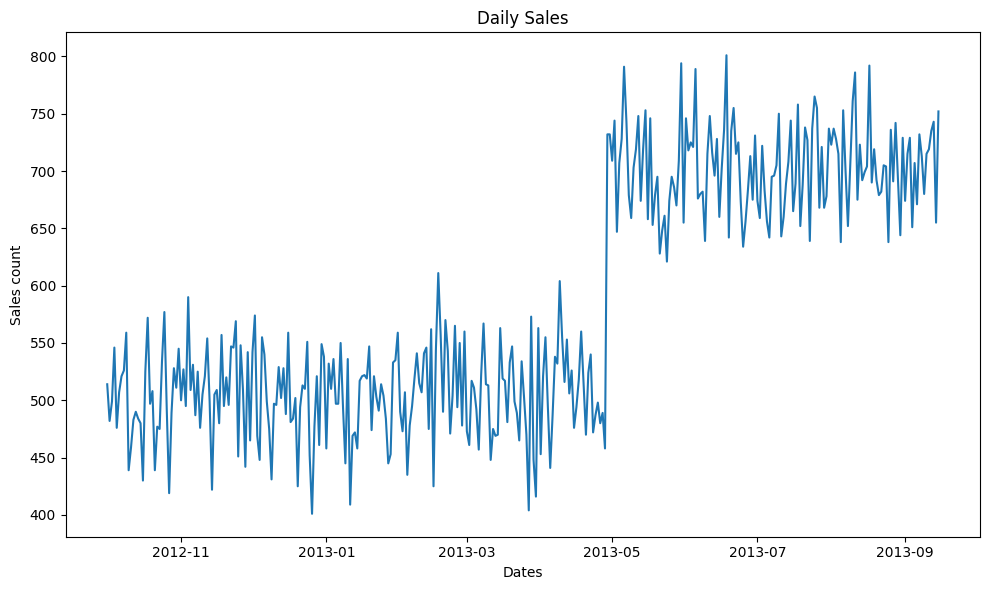

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(daily_sales['sale_time'], daily_sales['daily_sales'])
plt.title("Daily Sales")
plt.xlabel("Dates")
plt.ylabel("Sales count")
plt.tight_layout()

### Subproblem 2

It looks like there has been a sudden change in daily sales. What date did it occur?


In [56]:
daily_sales['diff'] = daily_sales['daily_sales'].diff().abs()
sudden_change_date = daily_sales.iloc[daily_sales['diff'].idxmax()]['sale_time']
sudden_change_date.strftime('%Y-%m-%d')

'2013-04-29'

### Subproblem 3


Is the change in daily sales at the date you selected statistically significant? If so, what is the p-value?


#### Thought Process

In the graph, we see a sudden and lasting shift in the daily sales in the time series of dates.
Thus this can imply a **structural break** or **change point** like a new marketing strategy.

To test if this change was statistically significant, we will be **spliting** this time series into before & after this change point.
- This means we are no longer assuming "one population" of daily sales.
- We will split the timeline into *two groups*
    
    ㄴ> to find out : Did something fundamentally change?
- Similar to : AB testing, Intervention analysis(policy implementation)

So now, we will be using the **t-test**.
-> effect size, p-value



Then three things to consider :

1. Independence of observations

2. Normality(or large sample)

3. Equal variance between groups

1,2 is good to go but 3 is an ehh..

So we will go with Welch's t-test which is more robust to variance.

In [58]:
before = daily_sales[daily_sales['sale_time'] < sudden_change_date]['daily_sales']
after = daily_sales[daily_sales['sale_time'] > sudden_change_date]['daily_sales']

var_before = before.var()
var_after = after.var()

print(f"Change date: {sudden_change_date}")
print(f"Variance before change: {var_before:.2f}")
print(f"Variance after change: {var_after:.2f}")


Change date: 2013-04-29
Variance before change: 1600.13
Variance after change: 1551.45


In [64]:
from scipy.stats import ttest_ind

# Welch's t-test (equal_var=False )
t_stat, p_value = ttest_ind(before, after, equal_var=False)

print(f"Change Date: {sudden_change_date}")
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.6f}")


Change Date: 2013-04-29
T-statistic: -45.7536
P-value: 0.000000


- T-statistic : how different two sample means are, relative to the variance.

- P-value : If two groups actually have the same mean, what is the probability that 
you'd see a t-statistic this extreme or more

Thus, the change in daily sales at the date selected, is statistically significant, 

with the p-value nearly 0.

### Subproblem 4


Does the data suggest that the change in daily sales is due to a shift in the proportion of male-vs-female customers? Please use plots to support your answer (a rigorous statistical analysis is not necessary).


In [86]:
gender_counts = csv_concat.groupby(['sale_time','purchaser_gender']).size().unstack()
gender_counts['female_ratio'] = gender_counts['female'] / (gender_counts['female'] + gender_counts['male']) * 100


Text(0, 0.5, 'Female Ratio')

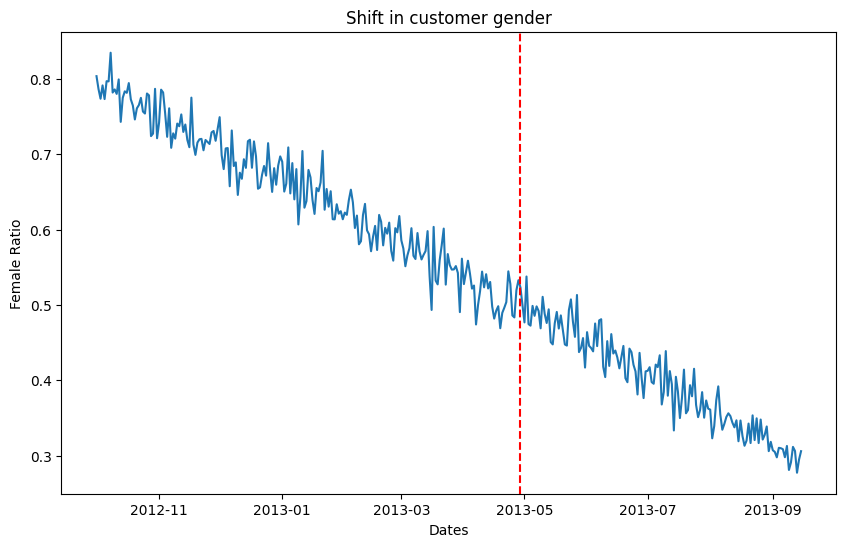

In [89]:
plt.figure(figsize=(10,6))
plt.plot(gender_counts['female_ratio'])
plt.axvline(x=pd.to_datetime('2013-04-29'), color='red', linestyle='--', label='Change Date')
plt.title('Shift in customer gender')
plt.xlabel('Dates')
plt.ylabel('Female Ratio')

Gender shift is probably not the reason of the leap in daily sales.

Female ratio is declining steadily whereas the sales leaped significantly.

### Subproblem 5


Assume a given day is divided into four dayparts:

night (12:00AM - 6:00AM),

morning (6:00AM - 12:00PM),

afternoon (12:00PM - 6:00PM),

evening (6:00PM - 12:00AM).

What is the percentage of sales in each daypart over all 50 weeks?


In [91]:
def get_dayparts(hour):
    if 0<=hour<6 :
        return "night"
    elif 6<=hour<12 :
        return "morning"
    elif 12<=hour<18 :
        return "afternoon"
    else :
        return "evening"

In [104]:
df = pd.concat(csv_calls, axis=0)
df['hour'] = pd.to_datetime(df['sale_time']).dt.hour
df['daypart'] = df['hour'].apply(get_dayparts)
daypart_counts = df['daypart'].value_counts().sort_index()
daypart_percentages = (daypart_counts / len(csv_concat)) * 100
daypart_percentages


daypart
afternoon    39.413397
evening      20.858517
morning      30.769005
night         8.959081
Name: count, dtype: float64